In [74]:
import cfbd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'j5Z7/ASYjq4l6PMJFJpY7WxwO5BtbY/U2TFBOVdziGKRvjI8WajGUnVRiUBGrIX8'
configuration.api_key_prefix['Authorization'] = 'Bearer'

games_api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
metrics_api_instance = cfbd.MetricsApi(cfbd.ApiClient(configuration))
plays_api_instance = cfbd.PlaysApi(cfbd.ApiClient(configuration))

id: 401520162 home: Michigan away: East Carolina
initial win prob: 0.976, final: 1.000


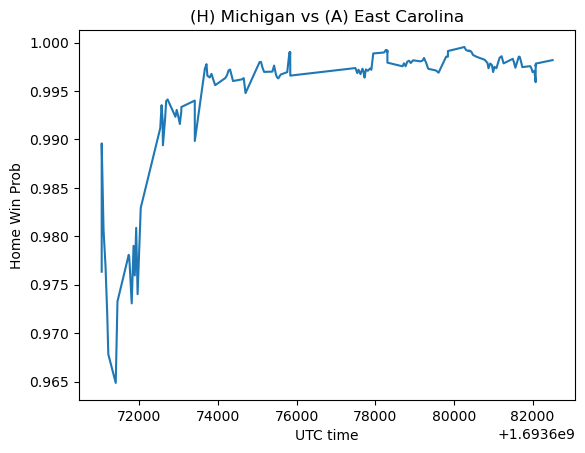

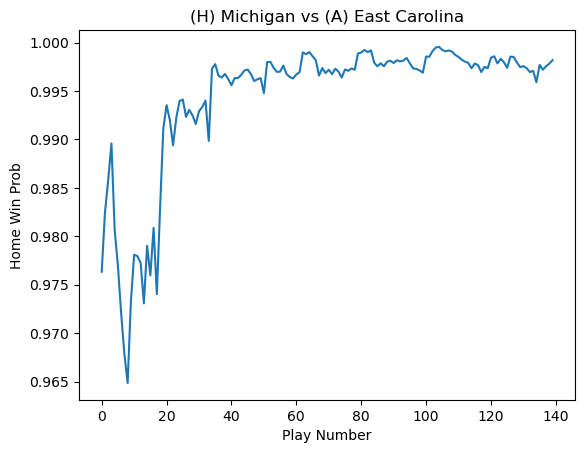

id: 401551786 home: Michigan away: Alabama
initial win prob: 0.533, final: 1.000


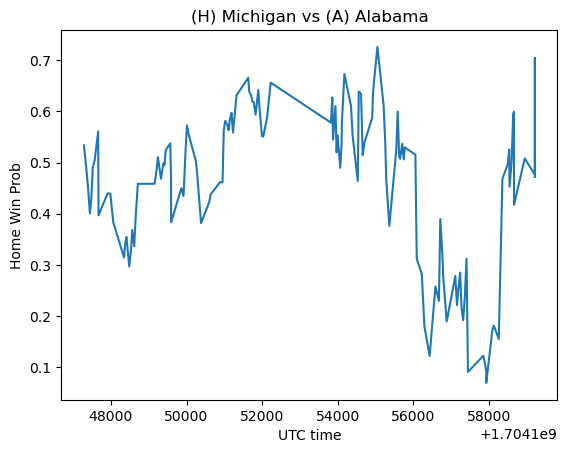

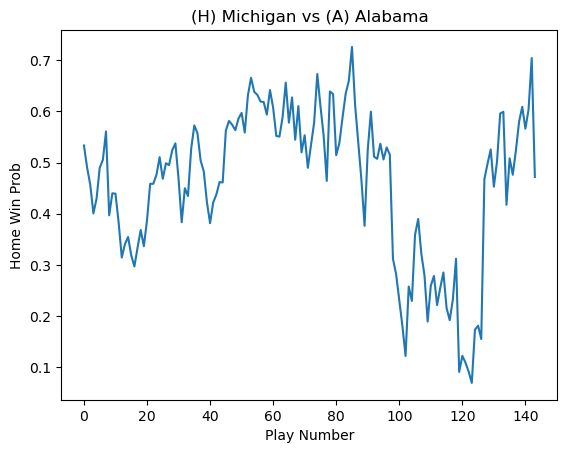

In [82]:
YEAR = 2023

# TODO: not just michigan
# TODO: timezones
# TODO: output to file

for season_type in ('regular', 'postseason'):
    games = games_api_instance.get_games(year=YEAR, team='michigan', season_type=season_type)
    for game in games:
        output = []
        print(f'id: {game._id} home: {game._home_team} away: {game._away_team}')
        wp = metrics_api_instance.get_win_probability_data(game_id=game._id)
        print(f'initial win prob: {wp[0]._home_win_prob:.3f}, final: {wp[-1]._home_win_prob:.3f}')
        plays = plays_api_instance.get_plays(year=YEAR, week=game._week, team=game._home_team, season_type=season_type)
        for i in range(len(wp)-1):
            j = i
            while (wp[i]._play_id != plays[j]._id and j < len(plays)):
                j += 1
                
            # Convert string to datetime object. TODO: which time zone? Currently, GMT
            dt_utc = None
            if plays[j]._wallclock is not None:
                dt_utc = datetime.fromisoformat(plays[j]._wallclock).astimezone(tz=None).timestamp()
                # Don't allow timestamp for a given play to be before a previous play!
                if i > 1 and dt_utc < output[-1]['utc']:
                    dt_utc = output[-1]['utc'] + 1
                if (wp[i]._play_id == plays[j]._id):
                    agg_play = {
                        'play_id' : wp[i]._play_id,
                        'home_win_prob' : wp[i]._home_win_prob,
                        'wallclock' : plays[j]._wallclock,
                        'utc': dt_utc,
                    }
                    output.append(agg_play)

        # Plotting win percentage
        time = [play['utc'] for play in output]
        wp_list = [play['home_win_prob'] for play in output]
        plot = plt.plot(time, wp_list)
        plt.xlabel('UTC time')
        plt.ylabel('Home Win Prob')
        plt.title(f'(H) {game._home_team} vs (A) {game._away_team}')
        plt.show()
        
        plot = plt.plot(range(len(output)), wp_list)
        plt.xlabel('Play Number')
        plt.ylabel('Home Win Prob')
        plt.title(f'(H) {game._home_team} vs (A) {game._away_team}')
        plt.show()
        break

In [84]:
output

[{'play_id': 401551786101854601,
  'home_win_prob': 0.5332525969,
  'wallclock': '2024-01-01T22:14:46.000Z',
  'utc': 1704147286.0},
 {'play_id': 401551786101855601,
  'home_win_prob': 0.4901971817,
  'wallclock': '2024-01-01T22:15:46.000Z',
  'utc': 1704147346.0},
 {'play_id': 401551786101859401,
  'home_win_prob': 0.4565757513,
  'wallclock': '2024-01-01T22:16:28.000Z',
  'utc': 1704147388.0},
 {'play_id': 401551786101864301,
  'home_win_prob': 0.4007106721,
  'wallclock': '2024-01-01T22:17:24.000Z',
  'utc': 1704147444.0},
 {'play_id': 401551786101865101,
  'home_win_prob': 0.4294261336,
  'wallclock': '2024-01-01T22:18:01.000Z',
  'utc': 1704147481.0},
 {'play_id': 401551786101868701,
  'home_win_prob': 0.4897168875,
  'wallclock': '2024-01-01T22:18:38.000Z',
  'utc': 1704147518.0},
 {'play_id': 401551786101877201,
  'home_win_prob': 0.5052541494,
  'wallclock': '2024-01-01T22:19:31.000Z',
  'utc': 1704147571.0},
 {'play_id': 401551786101884701,
  'home_win_prob': 0.5605643988,
  '